In [465]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, auc, roc_curve
import re
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.auto import tqdm
RAND = 10

In [364]:
df = pd.read_excel('data.xlsx')

# Вспомогательное

In [365]:
token_counter = Counter()
for one_string in df['text'].values:
    for token in one_string.split():
        token_counter[token] += 1

In [366]:
def remove_words_with_substring(text, substring):
    pattern = rf'\b\w*{re.escape(substring)}\w*\b'
    result = re.sub(pattern, '', text)
    return ' '.join(result.split())
df['text'] = df['text'].apply(lambda x: remove_words_with_substring(x, 'token'))

In [367]:
to_del = set([i for i, v in token_counter.items() if len(i) == 1])

In [369]:
# low_appearance = set([token for token,count in token_counter.items() if count < 3])
low_appearance = set()
garbage = to_del.union(low_appearance)
def delete_garbage(text, garbage):
    return ' '.join([i for i in text.split() if i not in garbage])

df['text'] = df['text'].apply(lambda x: delete_garbage(x, garbage))

In [370]:
def find_lenght(text):
    return len(text.split())
df['length'] = df['text'].apply(lambda x: find_lenght(x))
df['length'].describe()

count    47955.000000
mean        38.700636
std         44.614227
min          2.000000
25%         11.000000
50%         22.000000
75%         48.000000
max        358.000000
Name: length, dtype: float64

Идея, что будет дальше: так как у нас много разных слов, и есть слова которые встречаются очень редко, по сравнению с другими =>
<br> давайте не будем учитывать слова, которые встречались меньше {treshold} раз. в данном случае я взял 10. Так как для них мы все равно ничего не выучим.
<br> Просто заменим на UNK

In [371]:
token_counter = Counter()
for one_string in df['text'].values:
    for token in one_string.split():
        token_counter[token] += 1

In [372]:
token_world = sorted([i for i, v in token_counter.items() if v > 10])
unknown, padding = 'unk', 'pad'
token_world = [unknown, padding] + token_world

In [373]:
token_to_index = dict()
for i,v in enumerate(token_world):
    token_to_index[v] = i

In [374]:
UNK_IX, PAD_IX = map(token_to_index.get, [unknown, padding])
def as_matrix(sequences, max_len=50):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_index.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    return matrix

In [375]:
print("Lines:")
print('\n'.join(df["text"][:3].values), end='\n\n')
print("Matrix:")
print(as_matrix(df["text"][:3], max_len=50))

Lines:
уход ислам мамедов плотный удушающего реакция команда
ждать диллона прошлый неделя обещать конец неделя строй соскучиться
энтони джошуа продолжать подготовка реванш усик мимо

Matrix:
[[12928  4553  6060  8539     0 10289  5124     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1]
 [ 3749     0  9863  7007  7374  5188  7007 11854 11467     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1]
 [14013  3262  9682  8665 10310 12842  6357     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1  

In [376]:
df.drop(columns=['class_name', 'length'], axis=1, inplace=True)

# Подготовка к НН

In [377]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=RAND, stratify=df['class'])
data_train.index = range(len(data_train))
data_test.index = range(len(data_test))

print("Train size = ", len(data_train))
print("Test size = ", len(data_test))

Train size =  38364
Test size =  9591


In [378]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
def to_tensors(batch, device):
    batch_tensors = dict()
    batch_tensors['text'] = torch.tensor(batch['text'], device=device, dtype=torch.int64)
    batch_tensors['class'] = torch.tensor(batch['class'], device=device, dtype=torch.int64)
    return batch_tensors

def make_batch(data, max_len=50, device=device):
    batch = {}
    batch["text"] = as_matrix(data["text"].values, max_len)
    batch['class'] = data['class'].values
    return to_tensors(batch, device)

In [379]:
batch = make_batch(data_train[:3], max_len=35)
batch

{'text': tensor([[ 8270, 10142,  6393,   559, 14060,  1131,  3896, 10847, 12415, 13807,
           8914,  5104, 13326,  5831,  8556,   468,   329,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1],
         [ 2270,  9432,  7973,  9936,  8475,   741,  3478,  8088,  7906, 11567,
          13709, 11213, 12927,  4620,  9447,     0,  2096,     0,  7382, 10139,
           7258,  6586,  1375,  7685,  7972, 11567,  8951,     1,     1,     1,
              1,     1,     1,     1,     1],
         [ 4245, 11971,  5352,  7323,  1276,     0, 12921,  4211, 12792,  4660,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1]], device='cuda:0'),
 'class': tensor([2, 9, 4], device='cuda:0')}

In [380]:
def get_metrics(model, data, batch_size=32, name="", device=device, **kw):
    y_true = []
    y_pred = []
    y_prob = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            outputs = model(batch['text'].to(device))
            probs = nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(batch['class'].to(device).cpu().numpy()) ## убрал .cpu() перед .numpy()
            y_pred.extend(preds.cpu().numpy()) ## убрал .cpu() перед .numpy()
            y_prob.extend(probs.cpu().numpy()) ## убрал .cpu() перед .numpy()

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['Precision_micro'] = precision_score(y_true, y_pred, average='micro')
    df_metrics['Precision_macro'] = precision_score(y_true, y_pred, average='macro')
    df_metrics['Recall_micro'] = recall_score(y_true, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_true, y_pred, average='macro')
    df_metrics['F1_micro'] = f1_score(y_true, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_true, y_pred, average='macro')
    return df_metrics

In [437]:
def get_report(model, data, batch_size=32, name="", device=device, **kw):
    y_true = []
    y_pred = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            outputs = model(batch['text'].to(device))
            probs = nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(batch['class'].to(device).cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    accuracy_cnn = dict()
    for i,v in enumerate(y_true):
        if v == y_pred[i]:
            accuracy_cnn[v] = accuracy_cnn.get(v, 0) + 1


    return pd.Series(accuracy_cnn).sort_index()/data_test['class'].value_counts().sort_index()

In [381]:
def iterate_minibatches(data, batch_size=32, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, max_len=50, **kwargs)
            yield batch

        if not cycle: break

# LSTM

In [298]:
BATCH_SIZE = 32
num_epochs = 13
embed_size = 64
hidden_size = 64
output_size = len(set(df['class'].tolist()))

In [299]:
class LSTM_Classifier(nn.Module):
    def __init__(self, embed_size, hid_size, out_size, device1, dropout=0.3):
        super(LSTM_Classifier, self).__init__()
        self.hs = hid_size
        self.embs = nn.Embedding(len(token_world), embed_size, device=device1)
        self.lstm = nn.LSTM(embed_size, hid_size, batch_first=True, device=device1)
        self.fc = nn.Linear(hid_size, out_size, device=device1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, idx):
        x = self.embs(idx)
        h0 = torch.zeros(1, x.size(0), self.hs, device=idx.device)
        c0 = torch.zeros(1, x.size(0), self.hs, device=idx.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout before the final layer
        out = self.fc(out)
        return out

In [305]:
model = LSTM_Classifier(embed_size, hidden_size, output_size, device, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=7e-4) ########

In [306]:
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)), total=len(data_train) // BATCH_SIZE):
        pred = model(batch['text'].to(device))
        loss = criterion(pred, batch['class'].to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

epoch: 0


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [1/13], Loss: 2.4838
epoch: 1


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [2/13], Loss: 2.2104
epoch: 2


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [3/13], Loss: 1.8056
epoch: 3


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [4/13], Loss: 1.4460
epoch: 4


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [5/13], Loss: 1.2074
epoch: 5


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [6/13], Loss: 1.2205
epoch: 6


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [7/13], Loss: 0.6925
epoch: 7


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [8/13], Loss: 0.8467
epoch: 8


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [9/13], Loss: 0.4250
epoch: 9


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [10/13], Loss: 0.8867
epoch: 10


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [11/13], Loss: 0.5638
epoch: 11


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [12/13], Loss: 0.7293
epoch: 12


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [13/13], Loss: 0.5994


In [307]:
lstm_res = get_metrics(model, data_train, BATCH_SIZE, name='lstm_train', device=device)
lstm_res = pd.concat([lstm_res, get_metrics(model, data_test, BATCH_SIZE, name='lstm_test', device=device)])
lstm_res

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro
0,lstm_train,0.900480,0.906006,0.900480,0.892089,0.900480,0.894889
0,lstm_test,0.772495,0.783641,0.772495,0.760754,0.772495,0.765984


# CNN

In [398]:
BATCH_SIZE = 32
num_epochs = 14
embed_size = 32
num_filters = 64
output_size = len(set(df['class'].tolist()))

In [399]:
class CNN_Classifier(nn.Module):
    def __init__(self, device1, embed_size=32, num_filters=64, output_size=10, dropout=0.3):
        super(CNN_Classifier, self).__init__()
        self.embs = nn.Embedding(len(token_world), embed_size, device=device1)
        self.conv = nn.Conv1d(embed_size, num_filters, kernel_size=3)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, idx):
        x = self.embs(idx)
        x = x.transpose(2, 1)
        outs = self.conv(x)
        max_pool = torch.max(outs, dim=-1).values
        max_pool = self.dropout(max_pool)
        output = self.fc(max_pool)
        return output

In [400]:
model = CNN_Classifier(device, embed_size, num_filters, output_size, dropout=0.35).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=2e-3)

In [401]:
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")

    model.train()
    for i, batch in tqdm(enumerate(iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)), total=len(data_train) // BATCH_SIZE):
        pred = model(batch['text'].to(device))
        loss = criterion(pred, batch['class'].to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

epoch: 0


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [1/14], Loss: 2.1027
epoch: 1


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [2/14], Loss: 1.7447
epoch: 2


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [3/14], Loss: 1.2110
epoch: 3


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [4/14], Loss: 1.0499
epoch: 4


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [5/14], Loss: 0.9005
epoch: 5


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [6/14], Loss: 1.3758
epoch: 6


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [7/14], Loss: 0.6677
epoch: 7


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [8/14], Loss: 0.6451
epoch: 8


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [9/14], Loss: 0.5867
epoch: 9


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [10/14], Loss: 0.5195
epoch: 10


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [11/14], Loss: 0.4990
epoch: 11


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [12/14], Loss: 0.6430
epoch: 12


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [13/14], Loss: 0.7853
epoch: 13


  0%|          | 0/1198 [00:00<?, ?it/s]

Epoch [14/14], Loss: 0.7192


In [403]:
cnn_res = get_metrics(model, data_train, BATCH_SIZE, name='CNN_train', device=device)
cnn_res = pd.concat([cnn_res, get_metrics(model, data_test, BATCH_SIZE, name='CNN_test', device=device)])
cnn_res

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro
0,CNN_train,0.856506,0.863521,0.856506,0.846115,0.856506,0.851587
0,CNN_test,0.797623,0.813782,0.797623,0.786064,0.797623,0.794664


In [445]:
dict_labels = {0:'esport', 1:'martial_arts', 2:'tennis', 3:'basketball',
        4:'volleyball', 5:'boardgames', 6:'athletics', 7:'winter_sport',
        8:'football', 9:'motosport', 10:'autosport', 11:'extreme', 12:'hockey'}


In [458]:
my_res = pd.DataFrame(get_report(model, data_test, BATCH_SIZE, name='CNN_test', device=device)).reset_index()

In [459]:
my_res['index'] = my_res['index'].map(dict_labels)
my_res.rename(columns={'index': 'class', 0: 'proportion'}, inplace=True)

In [460]:
my_res

,class,proportion
0,esport,0.830594
1,martial_arts,0.766010
2,tennis,0.921082
3,basketball,0.786395
4,volleyball,0.785298
5,boardgames,0.872159
6,athletics,0.807838
7,winter_sport,0.844141
8,football,0.781623
9,motosport,0.807087


<ipython-input-464-91b0b3263b78>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')


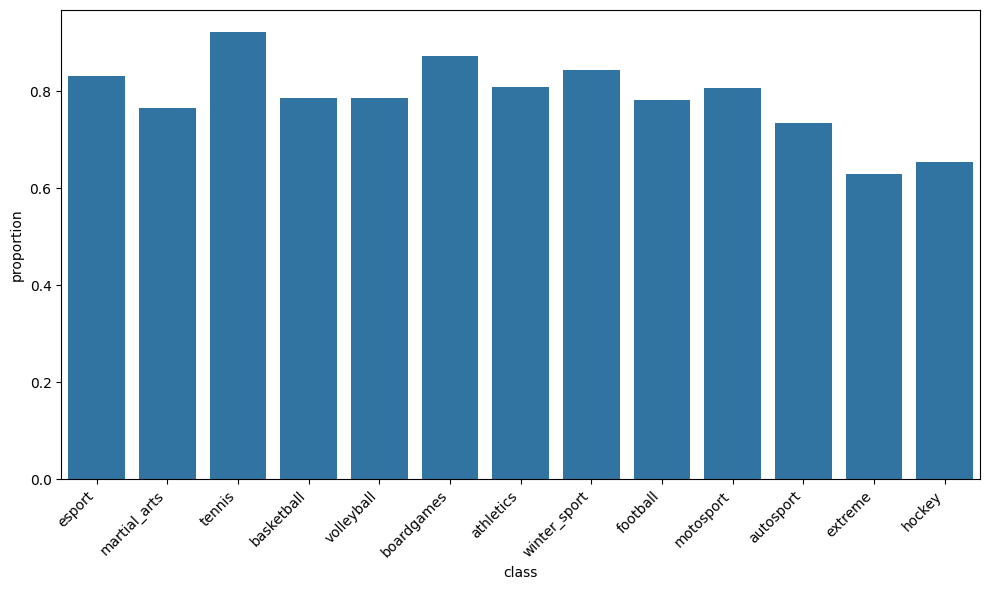

In [464]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='class', y='proportion', data=my_res)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()